In [94]:
# Import libraries and set desired options
import pickle
from pathlib2 import Path
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
# Read the training and test data sets, change paths if needed
PATH_TO_DATA = Path(r'D:\Programming\DS\mlcourse\course\jupyter_english\assignments_fall2019\Alice')

times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv(PATH_TO_DATA / 'train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(PATH_TO_DATA / 'test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [3]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(PATH_TO_DATA / 'site_dic.pkl', "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head(10)

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu
37491,img378.imageshack.us
5462,ecologie.nature.free.fr
35425,www.ibcn.intec.ugent.be
30151,kissanime.com
38268,www.carolineconduiteformation.com


In [4]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(10)
print(top_sites)
top_sites_df = sites_dict.loc[top_sites.drop(0).index]
top_sites_df

21     123776
0      122730
23      87619
782     77055
22      58258
29      54094
167     46405
780     43841
778     38194
52      36085
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com
167,www.bing.com
780,blast.ncbi.nlm.nih.gov
778,www.ncbi.nlm.nih.gov
52,clients1.google.com


In [5]:
top_alice_sites = pd.Series(train_df[train_df['target'] == 1][sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(10)
print(top_alice_sites)
top_sites_df = sites_dict.loc[top_alice_sites.index]
top_sites_df

77     1382
80     1354
76     1307
29      897
21      857
81      609
879     522
22      522
75      451
82      447
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr
81,r4---sn-gxo5uxg-jqbe.googlevideo.com
879,r1---sn-gxo5uxg-jqbe.googlevideo.com
22,apis.google.com
75,s.ytimg.com
82,r2---sn-gxo5uxg-jqbe.googlevideo.com


In [6]:
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df.head()

,target,min,max,seconds
session_id,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [7]:
time_stat_seconds = time_df.groupby(['target']).seconds.describe()
print("Описательные статистики:\n\n", time_stat_seconds, '\n\n')

count_other_sessions, count_alice_sessions = time_stat_seconds['count'].values
percent_of_alice_sessions = count_alice_sessions * 100 / count_other_sessions
print("Процент сессий Алисы среди общего количества сессий: ", percent_of_alice_sessions, '\n')

Описательные статистики:

            count        mean         std  min  25%   50%    75%     max
target                                                                 
0       251264.0  139.282372  296.653518  0.0  7.0  28.0  114.0  1800.0
1         2297.0   52.296474  153.309014  0.0  4.0  11.0   38.0  1763.0 


Процент сессий Алисы среди общего количества сессий:  0.9141779164544065 



In [8]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [9]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [10]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [11]:
full_sites_sparse

<336358x48371 sparse matrix of type '<class 'numpy.int32'>'
	with 3195430 stored elements in Compressed Sparse Row format>

In [34]:
tfidf_tr = TfidfTransformer()

In [36]:
full_sites_sparse_tf_idf = tfidf_tr.fit_transform(full_sites_sparse)

In [37]:
full_sites_sparse_tf_idf

<336358x48371 sparse matrix of type '<class 'numpy.float64'>'
	with 1866898 stored elements in Compressed Sparse Row format>

In [12]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [13]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195248606340787
Wall time: 4.99 s


In [38]:
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse_tf_idf[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9244205565941577


In [14]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [15]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

In [16]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

In [17]:
full_new_feat['target'] = train_df['target']
full_new_feat

,start_month,target
session_id,,
21669,201301.0,0
54843,201301.0,0
77292,201301.0,0
114021,201301.0,0
146670,201301.0,0
...,...,...
82793,201410.0,0
82794,201405.0,0
82795,201405.0,0


In [18]:
full_new_feat[full_new_feat['target'] == 1].start_month.value_counts().sort_index()

201302.0     61
201304.0     38
201309.0    377
201311.0    446
201312.0    134
201401.0    129
201402.0    410
201403.0    400
201404.0    302
201405.0    229
201406.0     54
201407.0     83
201408.0     69
201409.0     37
201410.0     80
201411.0     84
201412.0    121
Name: start_month, dtype: int64

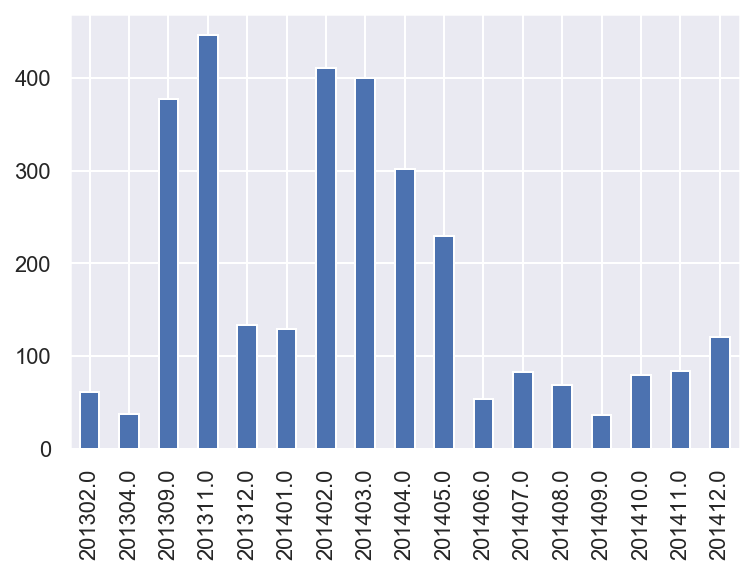

In [19]:
full_new_feat[full_new_feat['target'] == 1].start_month.value_counts().sort_index().plot.bar()

In [20]:
# Add the new feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse_[:idx_split,:], tmp[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9196993699549295


In [107]:
tmp 

array([[-1.381785  ],
       [-1.381785  ],
       [-1.381785  ],
       ...,
       [-0.42697503],
       [-0.74524502],
       [-0.74524502]])

In [21]:
def unic_sites_count(sites):
    unic_sites = []
    for site in sites:
        if site not in unic_sites:
            unic_sites.append(site)
    return len(unic_sites)

In [22]:
Unic_sites_df = pd.DataFrame()
Unic_sites_df['n_unique_sites'] = full_df[sites].apply(lambda x: unic_sites_count(x), axis=1)

In [23]:
Unic_sites_df

,n_unique_sites
session_id,
21669,3
54843,3
77292,6
114021,5
146670,6
...,...
82793,4
82794,6
82795,10


In [39]:
# Add the new feature to the sparse matrix
tmp = Unic_sites_df[['n_unique_sites']].values
tmp2 = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse_tf_idf[:idx_split,:], tmp[:idx_split,:], tmp2[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9198505560144727


In [40]:
# Add the new feature to the sparse matrix
tmp = StandardScaler().fit_transform(Unic_sites_df[['n_unique_sites']])
tmp2 = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse_tf_idf[:idx_split,:], tmp[:idx_split,:], tmp2[:idx_split,:]]))

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9192323763701096


In [26]:
# Dataframe for new features
full_start_hour_and_morning = pd.DataFrame(index=full_df.index)

# Add start_month features
full_start_hour_and_morning['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour).astype('float64')
full_start_hour_and_morning['morning'] = full_df['time1'].apply(lambda ts: 1 if ts.hour <= 11 else 0)

In [27]:
full_start_hour_and_morning

,start_hour,morning
session_id,,
21669,8.0,1
54843,8.0,1
77292,8.0,1
114021,8.0,1
146670,8.0,1
...,...,...
82793,18.0,0
82794,14.0,0
82795,11.0,1


In [42]:
# Add the new features to the sparse matrix
tmp = full_start_hour_and_morning[['start_hour']].values
tmp2 = full_start_hour_and_morning[['morning']].values
tmp_start_month = StandardScaler().fit_transform(full_new_feat[['start_month']])

X_train = csr_matrix(hstack([full_sites_sparse_tf_idf[:idx_split,:], 
                             tmp[:idx_split,:], 
                             tmp2[:idx_split,:], 
                             tmp_start_month[:idx_split,:]]))

# Compute the metric on the validation set
print('Скор с добавлением фич: часы(не масштабированная) и утро: ', get_auc_lr_valid(X_train, y_train))



# Add the new features to the sparse matrix
tmp = StandardScaler().fit_transform(full_start_hour_and_morning[['start_hour']])
tmp2 = full_start_hour_and_morning[['morning']].values
tmp_start_month = StandardScaler().fit_transform(full_new_feat[['start_month']])

X_train = csr_matrix(hstack([full_sites_sparse_tf_idf[:idx_split,:], 
                             tmp[:idx_split,:], 
                             tmp2[:idx_split,:], 
                             tmp_start_month[:idx_split,:]]))

# Compute the metric on the validation set
print('Скор с добавлением фич: часы(масштабированная) и утро: ', get_auc_lr_valid(X_train, y_train))



# Add the new features to the sparse matrix
tmp2 = full_start_hour_and_morning[['morning']].values
tmp_start_month = StandardScaler().fit_transform(full_new_feat[['start_month']])

X_train = csr_matrix(hstack([full_sites_sparse_tf_idf[:idx_split,:], 
                             tmp2[:idx_split,:], 
                             tmp_start_month[:idx_split,:]]))

# Compute the metric on the validation set
print('Скор с добавлением только фичи - утро: ', get_auc_lr_valid(X_train, y_train))



# Add the new features to the sparse matrix
tmp = full_start_hour_and_morning[['start_hour']].values
tmp_start_month = StandardScaler().fit_transform(full_new_feat[['start_month']])

X_train = csr_matrix(hstack([full_sites_sparse_tf_idf[:idx_split,:], 
                             tmp[:idx_split,:], 
                             tmp_start_month[:idx_split,:]]))

# Compute the metric on the validation set
print('Скор с добавлением только фичи - часы(не масштабированная): ', get_auc_lr_valid(X_train, y_train))



# Add the new features to the sparse matrix
tmp = StandardScaler().fit_transform(full_start_hour_and_morning[['start_hour']])
# tmp2 = full_start_hour_and_morning[['morning']].values
tmp_start_month = StandardScaler().fit_transform(full_new_feat[['start_month']])

X_train = csr_matrix(hstack([full_sites_sparse_tf_idf[:idx_split,:], 
                             tmp[:idx_split,:], 
                             tmp_start_month[:idx_split,:]]))

# Compute the metric on the validation set
print('Скор с добавлением только фичи - часы(масштабированная): ', get_auc_lr_valid(X_train, y_train))

Скор с добавлением фич: часы(не масштабированная) и утро:  0.9625878283069818
Скор с добавлением фич: часы(масштабированная) и утро:  0.9630165536281031
Скор с добавлением только фичи - утро:  0.9513574892879053
Скор с добавлением только фичи - часы(не масштабированная):  0.9633575714099387
Скор с добавлением только фичи - часы(масштабированная):  0.9636591887309247


In [29]:
full_new_feat['start_hour'] = full_start_hour_and_morning['start_hour']
full_new_feat['morning'] = full_start_hour_and_morning['morning']
full_new_feat

,start_month,target,start_hour,morning
session_id,,,,
21669,201301.0,0,8.0,1
54843,201301.0,0,8.0,1
77292,201301.0,0,8.0,1
114021,201301.0,0,8.0,1
146670,201301.0,0,8.0,1
...,...,...,...,...
82793,201410.0,0,18.0,0
82794,201405.0,0,14.0,0
82795,201405.0,0,11.0,1


In [79]:
def add_time_features(df_in):
    df = pd.DataFrame()
    df['morning'] = df_in['time1'].apply(lambda ts: 1 if ts.hour >= 7 and ts.hour <= 11 else -1)
    df['day'] = df_in['time1'].apply(lambda ts: 1 if ts.hour >= 12 and ts.hour <= 18 else -1)
    df['evening'] = df_in['time1'].apply(lambda ts: 1 if ts.hour >= 19 and ts.hour <= 23 else -1)
    df['night'] = df_in['time1'].apply(lambda ts: 1 if ts.hour >= 0 and ts.hour <= 6 else -1)
            
    return df

In [88]:
temp_df = add_time_features(full_df)
temp_df[:idx_split]

,morning,day,evening,night
session_id,,,,
21669,1,-1,-1,-1
54843,1,-1,-1,-1
77292,1,-1,-1,-1
114021,1,-1,-1,-1
146670,1,-1,-1,-1
...,...,...,...,...
12224,-1,-1,1,-1
164438,-1,-1,1,-1
12221,-1,-1,1,-1


In [96]:
# Compose the training set
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = hstack([full_sites_sparse_tf_idf[:idx_split,:], 
                             tmp_scaled[:idx_split,:], 
                             temp_df[:idx_split]])

In [97]:
time_split = TimeSeriesSplit(n_splits=10)

In [98]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((23051,), (23051,)),
 ((46102,), (23051,)),
 ((69153,), (23051,)),
 ((92204,), (23051,)),
 ((115255,), (23051,)),
 ((138306,), (23051,)),
 ((161357,), (23051,)),
 ((184408,), (23051,)),
 ((207459,), (23051,)),
 ((230510,), (23051,))]

In [99]:
logit = LogisticRegression(C=3.594, random_state=17, solver='liblinear')

In [100]:
cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=1)

In [101]:
cv_scores, cv_scores.mean()

(array([0.88846058, 0.80732501, 0.9502151 , 0.96855977, 0.91506794,
        0.95051924, 0.95128433, 0.92959065, 0.95331434, 0.95038256]),
 0.9264719525136194)

In [92]:
# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_temp, y_train)
print(score_C_1)

TypeError: 'coo_matrix' object is not subscriptable

In [91]:
# List of possible C-values
Cs = np.logspace(-3, 1, 10)
c_scores = {}
for C in Cs:
    C = round(C, 3)
    score = get_auc_lr_valid(X_train, y_train, C=C)
    score = round(score, 4)
    print(f'Скор при С = {C} : {score}')
    c_scores[C] = score


Скор при С = 0.001 : 0.9228
Скор при С = 0.003 : 0.9305
Скор при С = 0.008 : 0.9371
Скор при С = 0.022 : 0.9452
Скор при С = 0.06 : 0.9521
Скор при С = 0.167 : 0.9577
Скор при С = 0.464 : 0.9616
Скор при С = 1.292 : 0.9633
Скор при С = 3.594 : 0.9635
Скор при С = 10.0 : 0.9629


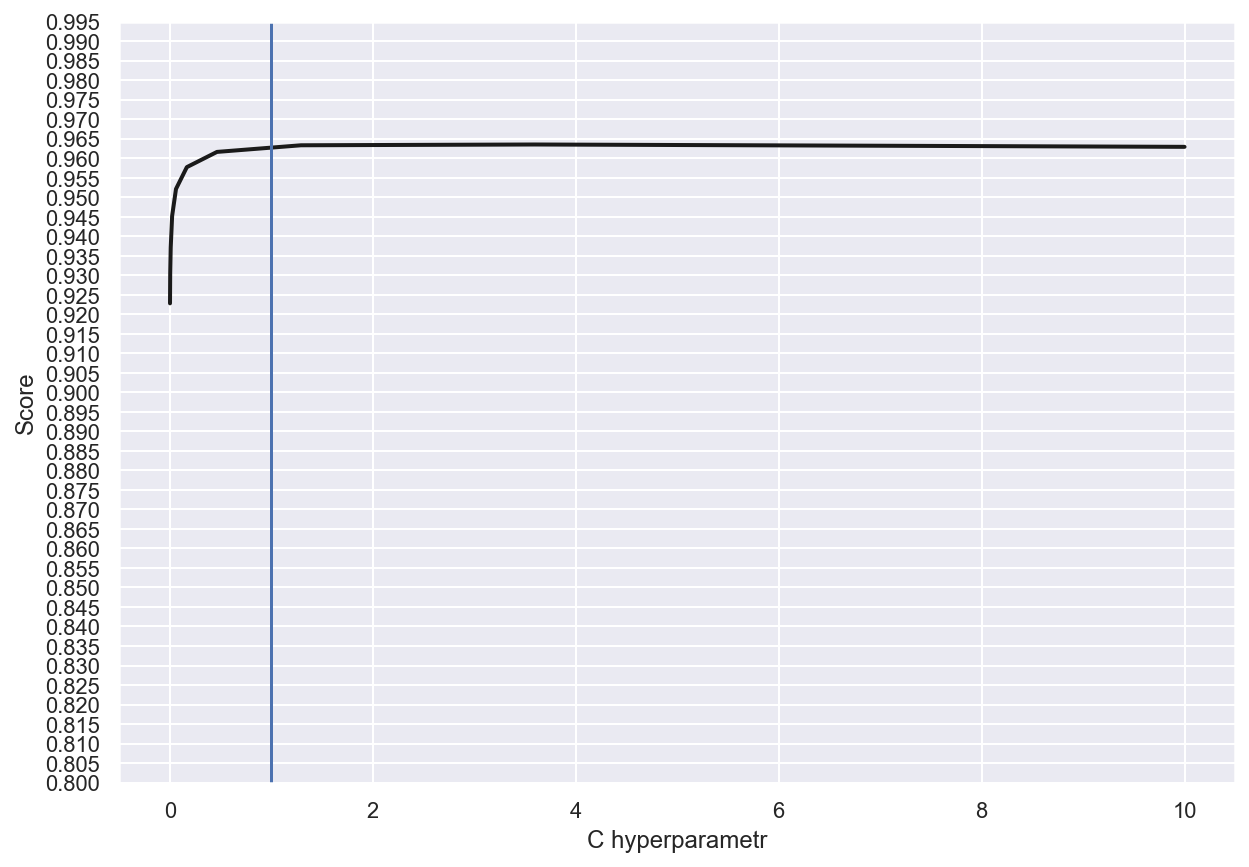

In [45]:
plt.figure(figsize=(10,7))
plt.plot(list(c_scores.keys()), list(c_scores.values()), color='k', lw=2)
plt.xlabel('C hyperparametr')
plt.ylabel('Score')
plt.yticks(np.arange(0.8, 1.0, 0.005))
plt.axvline(1, c='b')
plt.show()

In [102]:
logit.fit(X_train, y_train)

LogisticRegression(C=3.594, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [103]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)

In [104]:
%%time
logit_grid_searcher.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=3.594, class_weight=None,
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

In [105]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9264819117042021, {'C': 4.6415888336127775})

In [106]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month']])

# Make a prediction for test data set
X_test = hstack([full_sites_sparse_tf_idf[idx_split:,:], 
                             tmp_scaled[idx_split:,:], 
                             temp_df[idx_split:]])


y_test = logit_grid_searcher.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_3.csv')